### Timeseries Analysis using NDVI over selected Area

#### Importing of libraries

In [34]:
import matplotlib.pyplot as plt
import geopandas as gpd

from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

from dea_tools.spatial import xr_rasterize

from odc import stac

#### Selecting of Area of Interest using a vector file

In [4]:
area_of_interest = gpd.read_file('data/new_site.geojson')
area_of_interest.explore(column=area_of_interest.columns[0])

####  Loading of data from the Planetary API Stac

In [5]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
time_of_interest = "2018-01-01/2020-12-31"

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest.geometry[0],
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 50}},
)
# Check how many items were returned
items = list(search.get_items(),)
print(f"Returned {len(items)} Items")

Returned 98 Items


### Convert STAC data to ODC Data format

In [79]:
ds = stac.load(
    search.get_items(),
    bands=["red", "nir"],
    crs="EPSG:32606",
    resolution=-30,
    patch_url=pc.sign,
    chunks={'time':1, 'y':1000, 'x': 1000}
)
ds


<xarray.Dataset>
Dimensions:      (y: 5180, x: 5180, time: 98)
Coordinates:
  * y            (y) float64 -2.42e+06 -2.42e+06 ... -2.264e+06 -2.264e+06
  * x            (x) float64 -3.279e+06 -3.279e+06 ... -3.434e+06 -3.434e+06
    spatial_ref  int32 32606
  * time         (time) datetime64[ns] 2018-01-04T22:19:29.027000 ... 2020-12...
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

### Calculate NDVI

In [88]:
# Crop the Xarray to the area of interest
minx, miny, maxx, maxy = area_of_interest.to_crs(ds.odc.crs.to_epsg()).total_bounds
ds_clipped = ds.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

# Mask out by the geometry of the field
mask = xr_rasterize(area_of_interest, ds_clipped)
ds_clipped = ds_clipped.where(mask)

# Mask out nodata
ds_clipped = ds_clipped.where(ds_clipped != 0)

# Scale the values in place
ds_clipped = ds_clipped * 2.75e-5 - 0.2
ds_clipped

# Calculate NDVI
ds_clipped['ndvi'] = (ds_clipped["nir"] - ds_clipped["red"]) / (ds_clipped["nir"] + ds_clipped["red"])

ds_clipped

<xarray.Dataset>
Dimensions:      (y: 67, x: 54, time: 98)
Coordinates:
  * y            (y) float64 -2.385e+06 -2.385e+06 ... -2.383e+06 -2.383e+06
  * x            (x) float64 -3.326e+06 -3.326e+06 ... -3.328e+06 -3.328e+06
  * time         (time) datetime64[ns] 2018-01-04T22:19:29.027000 ... 2020-12...
    spatial_ref  int64 0
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 67, 54), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 67, 54), meta=np.ndarray>
    ndvi         (time, y, x) float32 dask.array<chunksize=(1, 67, 54), meta=np.ndarray>

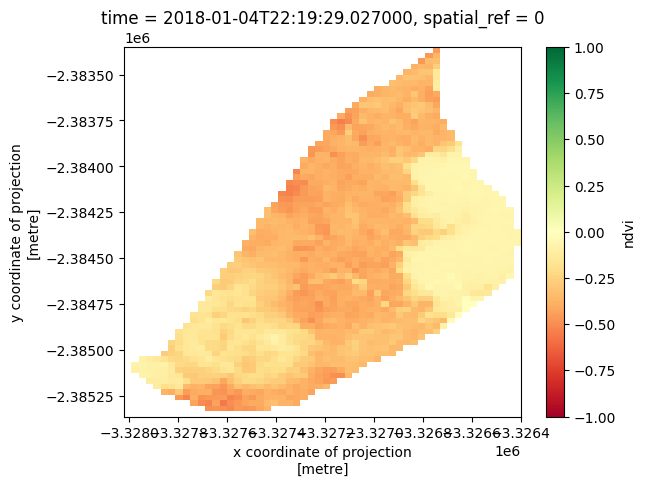

In [89]:
# Plot the first timestep as a sanity check
ds_clipped.ndvi.isel(time=0).plot.imshow(cmap="RdYlGn", vmin=-1, vmax=1)

### Compute the timeseries analysis

In [90]:
# Now compute the mean of NDVI for each timestep for the field
# This is calling compute() too, which means it will actually load data.
ndvi_mean = ds_clipped['ndvi'].mean(dim=["x","y"]).compute()

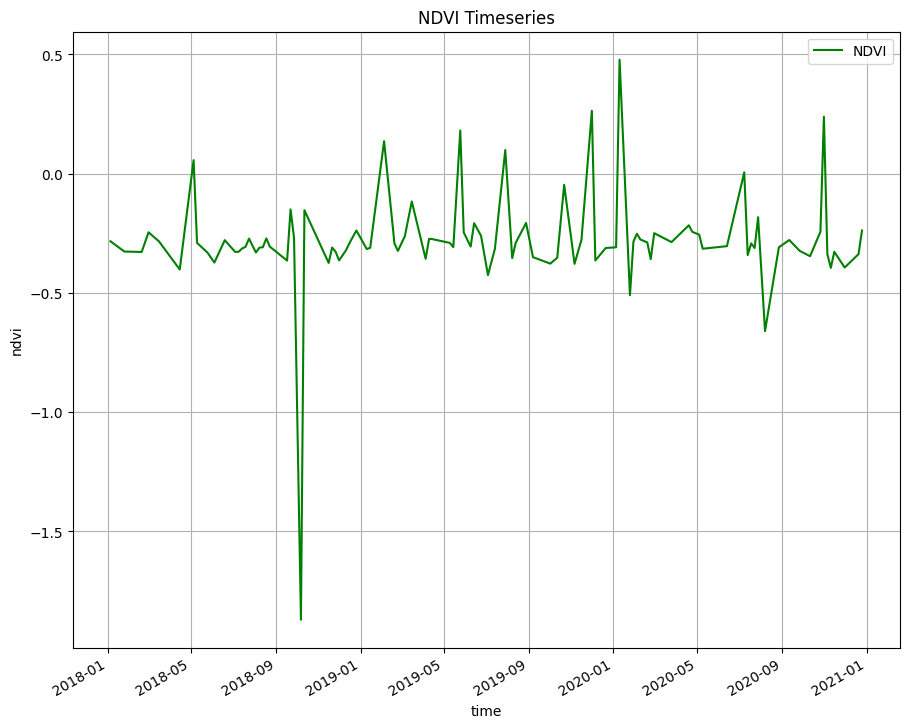

In [93]:
ndvi_mean.plot(color= 'green',label='NDVI', size=8)
plt.legend(loc='best')
plt.title("NDVI Timeseries")
plt.grid()

(-1.0, 1.0)

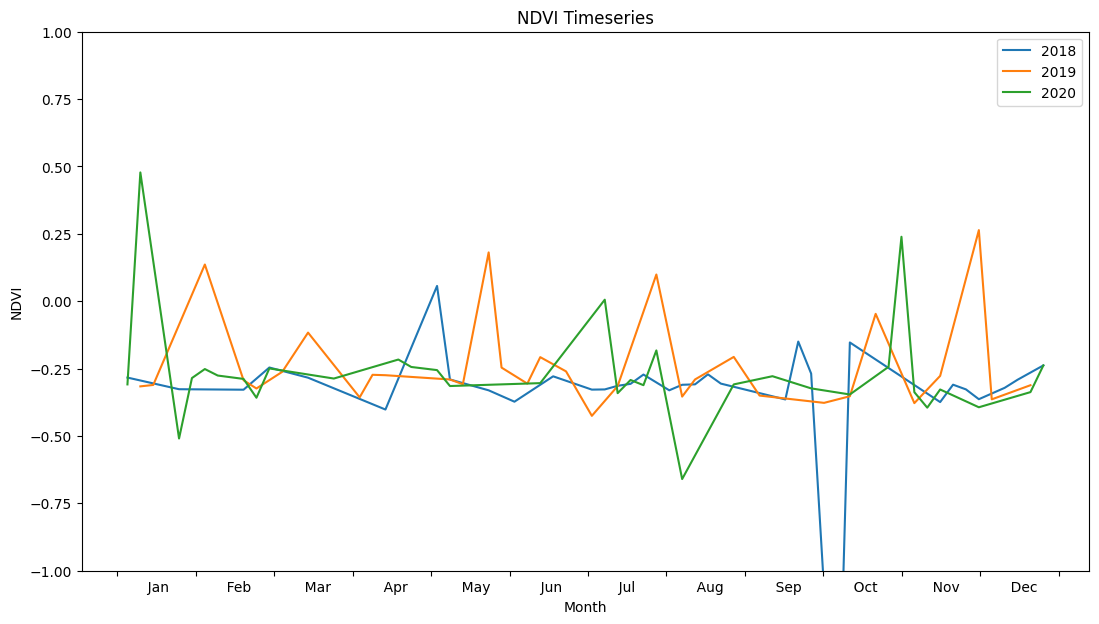

In [98]:
import numpy as np
years=ndvi_mean.groupby('time.year')
years_int=[y[0] for y in years]

fig, ax = plt.subplots()
fig.set_size_inches(13,7)

for year, y in zip(years, years_int):
    
    year[1].groupby('time.dayofyear').mean().plot(ax=ax, label=year[0])

ax.legend()
month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec', '']
mon=[]
for m in month:
    mon.append('       %s'%m)
plt.xticks(np.linspace(0,365,13), mon, horizontalalignment='left')
plt.xlabel('Month')
plt.ylabel('NDVI')

plt.title('NDVI Timeseries')

# Limit the plot to -1 and 1
plt.ylim(-1,1)
